## k-step hypergraphs

In [2]:
import pickle
import numpy as np
import networkx as nx
import scipy
import matplotlib.pyplot as plt
from itertools import product, permutations
from collections import defaultdict
from copy import copy

import scienceplots

plt.style.use(['science'])

from useful_functions import *

In [3]:
def findPaths(G,u,k):
    if k == 0:
        return [[u]]
    paths = [[u]+path for neighbor in G.neighbors(u) for path in findPaths(G,neighbor,k-1)]
    return paths


In [4]:
def to_step_tensor(G, k):
    
    tensor_dict = defaultdict(lambda: 0)
    
    for node in G.nodes:
        
        for hyperedge in findPaths(G,node,k-1):
            
            tensor_dict[tuple(hyperedge)] += 1
        
    return dict(tensor_dict), tuple([len(G.nodes)]*k)

## Test

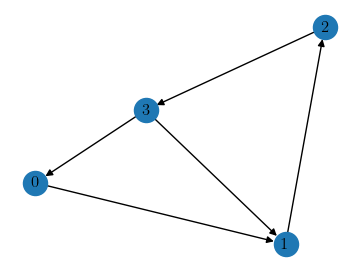

In [4]:
G = nx.cycle_graph(4,create_using=nx.DiGraph)
G.add_edge(3,1)
nx.draw(G, with_labels=True)

In [89]:
findPaths(G, 0, 2), findPaths(G, 1, 2), findPaths(G, 2, 2), findPaths(G, 3, 2)

([[0, 1, 2]], [[1, 2, 3]], [[2, 3, 0], [2, 3, 1]], [[3, 0, 1], [3, 1, 2]])

In [91]:
T = to_step_tensor(G,3)
T

({(0, 1, 2): 1,
  (1, 2, 3): 1,
  (2, 3, 0): 1,
  (2, 3, 1): 1,
  (3, 0, 1): 1,
  (3, 1, 2): 1},
 (4, 4, 4))

In [92]:
cent, converged = HEC_ours(T, m=3, niter=100000, tol=1e-6, verbose=True)

Finished in 12 iterations.


In [94]:
nx.eigenvector_centrality_numpy(G)

{0: 0.35310459653175785,
 1: 0.6423581763644165,
 2: 0.5262021618330159,
 3: 0.4310503474632474}

In [93]:
cent

array([0.22174117, 0.23293085, 0.27532452, 0.27000346])

In [95]:
converged

True

## Some datasets

In [22]:
with open("DirectedNets/moreno_blogs.pkl", 'rb') as f:
    G = pickle.load(f)

largest = max(nx.strongly_connected_components(G), key=len)
G = nx.subgraph(G,largest)

G = nx.convert_node_labels_to_integers(G, ordering="sorted")

In [33]:
nx.is_strongly_connected(G)

True

In [60]:
T = to_step_tensor(G,3)

In [61]:
cent3, converged = HEC_ours(T, m=3, niter=100000, tol=1e-6, verbose=True)

HEC3 = {}
for i, c in enumerate(cent3):
    HEC3[i] = c 
    
converged

Finished in 21 iterations.


True

In [62]:
T = to_step_tensor(G,4)

In [63]:
cent4, converged = HEC_ours(T, m=4, niter=100000, tol=1e-6, verbose=True)

HEC4 = {}
for i, c in enumerate(cent4):
    HEC4[i] = c 
    
converged

Finished in 22 iterations.


True

In [64]:
EC = nx.eigenvector_centrality_numpy(G)
scipy.stats.kendalltau(list(EC.values()), list(HEC3.values())).statistic, 
scipy.stats.kendalltau(list(EC.values()), list(HEC4.values())).statistic

0.37594435380216823

In [65]:
KendalltopK_H3E = []
for k in range(1, len(HEC3)):
                        
    topk1 = topN(HEC3, N=k)
    centrals2 = [EC[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_H3E.append(coeff)

KendalltopK_EH3 = []
for k in range(1, len(HEC3)):
                        
    topk1 = topN(EC, N=k)
    centrals2 = [HEC3[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_EH3.append(coeff)

KendalltopK_H4E = []
for k in range(1, len(HEC4)):
                        
    topk1 = topN(HEC4, N=k)
    centrals2 = [EC[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_H4E.append(coeff)
    

KendalltopK_EH4 = []
for k in range(1, len(HEC4)):
                        
    topk1 = topN(EC, N=k)
    centrals2 = [HEC4[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_EH4.append(coeff)


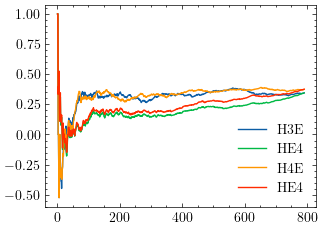

In [66]:
plt.plot(KendalltopK_H3E, label="H3E")
plt.plot(KendalltopK_EH3, label="HE4")
plt.plot(KendalltopK_H4E, label="H4E")
plt.plot(KendalltopK_EH4, label="HE4")

plt.legend()

In [67]:
KendalltopK_H43 = []
for k in range(1, len(HEC4)):
                        
    topk1 = topN(HEC4, N=k)
    centrals2 = [HEC3[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_H43.append(coeff)
    

KendalltopK_H34 = []
for k in range(1, len(HEC4)):
                        
    topk1 = topN(HEC3, N=k)
    centrals2 = [HEC4[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_H34.append(coeff)

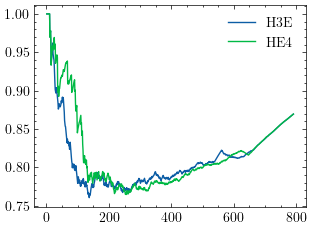

In [68]:
plt.plot(KendalltopK_H34, label="H3E")
plt.plot(KendalltopK_H43, label="HE4")

plt.legend()

In [69]:
T = to_step_tensor(G,2)

In [70]:
cent2, converged = HEC_ours(T, m=2, niter=100000, tol=1e-6, verbose=True)

HEC2 = {}
for i, c in enumerate(cent2):
    HEC2[i] = c 
    
converged

Finished in 15 iterations.


True

In [71]:
EC = nx.eigenvector_centrality_numpy(G)
scipy.stats.kendalltau(list(EC.values()), list(HEC2.values())).statistic

0.32767321823705214